In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
from datasets import load_dataset

import dl_translate as dlt

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline

In [2]:
# !python -m spacy download en_core_web_lg
!export CUDA_LAUNCH_BLOCKING=1
import spacy
import spacy_transformers
import torch

tqdm.pandas()

# English processing use cases
This notebook aims to test the Task and Object identification in patents in english.

1. **Task:** the method used in the described patent. In can be compress something or agilize a effect, for example.
2. **Object:** the "target" of the task. It can be a food, a construction material or any other object that, combined with the task, defines the patent.

It is supposed that NLP techniques are more refined to english data as the models are well-developed and to validate this theory, all the patents will be translated to english to them be processed.

[DL-Translate](https://pypi.org/project/dl-translate/), a Python library that implements a low verbosity use of many open source models to translation tasks.

Three models can be used to translate from portuguese to english:
- [mBART-50 Large](https://huggingface.co/transformers/master/model_doc/mbart.html): Allows translations across 50 languages.
- [m2m100](https://huggingface.co/docs/transformers/model_doc/m2m_100): Allows translations across 100 languages.
- [nllb-200](https://huggingface.co/docs/transformers/model_doc/nllb): Allows translations across 200 languages, and is faster than m2m100 (On RTX A6000, we can see speed up of 3x).

# Model translation evaluation

To test the models we will evaluate using [FLORES+](https://huggingface.co/datasets/openlanguagedata/flores_plus) from Meta and evaluate the BLEU score for each model. This will serve as a benchmark to choose the best translating model to portuguese.

To do so, we have to download the portuguese and english bases and combine then by the ID.

In [ ]:
df_merged = pd.read_excel('../../data/raw/basefinal_traducao_patentes.xlsx')
df_merged.head()

,id_pedido,data_deposito,titulo,ipc,url,resumo,classifica_ipc,priority_number,wo_number,idioma_titulo_1,titulo_1,idioma_titulo_2,titulo_2,idioma_resumo_1,resumo_1,idioma_resumo_2,resumo_2
0,BR 11 2022 012942 4,31/12/2020,SISTEMA DE MONITORAMENTO PARA AVALIAÇÃO DE UMA...,G01R 19/25,https://busca.inpi.gov.br/pePI/servlet/Patente...,"Trata-se, em geral, de um sistema de monitoram...",G01R 19/25 ; G01R 15/16 ; G01R 31/08 ; G0...,US2020067683,WO2020US67683,fr,SYSTÈME DE SURVEILLANCE POUR ÉVALUER UN ÉTAT D...,en,MONITORING SYSTEM FOR EVALUATING A CONDITION O...,en,"In general, a monitoring system includes one o...",fr,"En général, un système de surveillance compren..."
1,BR 11 2022 016299 5,31/12/2020,DISPOSITIVO E MÉTODO DE GRANULAÇÃO DE ESCÓRIA ...,C21B 3/06,https://busca.inpi.gov.br/pePI/servlet/Patente...,A presente invenção refere-se a dispositivo e ...,C21B 3/06 ; C21B 3/08 ; F27D 17/00 ; C03C...,CN2020141914,WO2020CN141914,fr,GRANULATION DE LAITIER DE HAUT FOURNEAU ET DIS...,en,BLAST FURNACE SLAG GRANULATION AND WASTE HEAT ...,en,Disclosed are a blast furnace slag granulation...,fr,L'invention concerne un dispositif et un procé...
2,BR 11 2022 019861 2,31/12/2020,"MÉTODO, APARELHO, E DISPOSITIVO PARA OBTER MOD...",G06K 9/62,https://busca.inpi.gov.br/pePI/servlet/Patente...,"São fornecidos um método, um aparelho, e um di...",G06K 9/62 ; G06N 3/08 ; G06N 20/20,CN2020142061,WO2020CN142061,fr,PROCÉDÉ ET APPAREIL D'OBTENTION D'UN MODÈLE D'...,en,METHOD AND APPARATUS FOR OBTAINING ARTIFICIAL ...,en,A method and apparatus for obtaining an artifi...,fr,L'invention concerne un procédé et un appareil...
3,BR 11 2022 012917 3,31/12/2020,"COMPOSIÇÃO TÓPICA, KIT, MÉTODOS PARA TRATAR OU...",A61K 9/06,https://busca.inpi.gov.br/pePI/servlet/Patente...,A presente invenção se refere a novas formulaç...,A61K 9/06 ; A61K 9/08 ; A61K 9/107 ; A61K...,US2020067612,WO2020US67612,fr,COMPOSITION TOPIQUE COMPRENANT DU TOFACITINIB ...,en,TOPICAL COMPOSITION COMPRISING TOFACITINIB AND...,en,The present disclosure relates to novel topica...,fr,La présente invention concerne de nouvelles fo...
4,BR 11 2022 019389 0,31/12/2020,"MÉTODO, APARELHO, DISPOSITIVO, MEIO DE ARMAZEN...",H04W 48/16,https://busca.inpi.gov.br/pePI/servlet/Patente...,"Este pedido divulga um método, um aparelho, um...",H04W 48/16,CN2020142262,WO2020CN142262,fr,"PROCÉDÉ, APPAREIL ET DISPOSITIF DE GUIDAGE D'I...",en,"ROAMING GUIDANCE METHOD, APPARATUS AND DEVICE,...",en,The present application relates to the technic...,fr,La présente application se rapporte au domaine...


In [ ]:
df_merged = df_merged[['id_pedido', 'resumo', 'resumo_1']].rename(columns={'id_pedido': 'id', 'resumo': 'text_pt', 'resumo_1': 'text_en'})
df_merged.head()

,id,text_pt,text_en
0,BR 11 2022 012942 4,"Trata-se, em geral, de um sistema de monitoram...","In general, a monitoring system includes one o..."
1,BR 11 2022 016299 5,A presente invenção refere-se a dispositivo e ...,Disclosed are a blast furnace slag granulation...
2,BR 11 2022 019861 2,"São fornecidos um método, um aparelho, e um di...",A method and apparatus for obtaining an artifi...
3,BR 11 2022 012917 3,A presente invenção se refere a novas formulaç...,The present disclosure relates to novel topica...
4,BR 11 2022 019389 0,"Este pedido divulga um método, um aparelho, um...",The present application relates to the technic...


In [3]:
df_merged = pd.read_csv("../../data/processed/translation_benchmark_patents_wide.csv")
df_merged.head()

,id,text_pt,text_en,m2m100_translation,mbart50_translation,unicamp_pt_en_t5,facebook_nlb_200,helsink_opus_mult
0,BR 11 2022 012942 4,"Trata-se, em geral, de um sistema de monitoram...","In general, a monitoring system includes one o...",It is generally a monitoring system that inclu...,It's basically a surveillance system that invo...,"In general, this is a monitoring system that i...",It is generally a monitoring system that inclu...,"In general, it is a monitoring system that inc..."
1,BR 11 2022 016299 5,A presente invenção refere-se a dispositivo e ...,Disclosed are a blast furnace slag granulation...,The present invention refers to the device and...,This invention deals with the device and metho...,This invention refers to the device and method...,This invention refers to the device and method...,This invention refers to the device and method of
2,BR 11 2022 019861 2,"São fornecidos um método, um aparelho, e um di...",A method and apparatus for obtaining an artifi...,"A method, an apparatus, and a device are provi...","You provide a method, a device, and a device t...","A method, a device, and a device are provided ...","A method, a device, and a device are provided ...","A method, a device, and a device are provided ..."
3,BR 11 2022 012917 3,A presente invenção se refere a novas formulaç...,The present disclosure relates to novel topica...,This invention refers to new topical formulati...,This invention deals with new toxic formulatio...,This invention refers to new topical formulati...,This invention refers to new topical formulati...,This invention refers to new topical formulati...
4,BR 11 2022 019389 0,"Este pedido divulga um método, um aparelho, um...",The present application relates to the technic...,"This request discloses a method, a device, a d...","This request discloses a method, a device, a d...","This application discloses a method, a device,...","This request discloses a method, device, devic...","This request discloses a method, an apparatus,..."


In [4]:
print(f"Size of the evaluation dataset: {len(df_merged)}")

Size of the evaluation dataset: 3014


In [5]:
import torch

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {device} as {'cuda' if device == 0 else 'cpu'}")

Using device: 0 as cuda


First, we will process the data with m2m model

In [14]:
col_name = "m2m100_translation"

if not df_merged.columns.str.contains(col_name).any():
    mt = dlt.TranslationModel(model_or_path="m2m100", device="gpu")


    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: mt.translate(str(x), source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_patents_wide.csv", index=False)
    df_merged.head()

100%|██████████| 3014/3014 [2:37:29<00:00,  3.14s/it]  


Now mbart-50

In [7]:
# Traduzindo os textos em português para inglês usando o modelo mbart50
col_name = "mbart50_translation"

if not df_merged.columns.str.contains(col_name).any():
    mt_mbart50 = dlt.TranslationModel(model_or_path="mbart50", device="gpu")
    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: mt_mbart50.translate(str(x), source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_patents_wide.csv", index=False)

100%|██████████| 3014/3014 [2:57:43<00:00,  3.54s/it]  


Now unicamp-dl/translation-pt-en-t5

In [7]:
col_name = "unicamp_pt_en_t5"

if not df_merged.columns.str.contains(col_name).any():
    tokenizer = AutoTokenizer.from_pretrained("unicamp-dl/translation-pt-en-t5")
    model = AutoModelForSeq2SeqLM.from_pretrained("unicamp-dl/translation-pt-en-t5")

    pt_en_pipeline = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        device=device
    )

    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: pt_en_pipeline(f"translate Portuguese to English: {str(x)}")[0]['generated_text']
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_patents_wide.csv", index=False)

Device set to use cuda:0
100%|██████████| 3014/3014 [18:41<00:00,  2.69it/s]


Now facebook/nllb-200-distilled-600M

In [6]:
col_name = "facebook_nlb_200"

if not df_merged.columns.str.contains(col_name).any():
    tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
    model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

    translator = pipeline(
        "translation",
        model=model,
        tokenizer=tokenizer,
        src_lang="por_Latn",
        tgt_lang="eng_Latn",
        device=device,
        max_length=600
    )

    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: translator(str(x))[0]["translation_text"]
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_patents_wide.csv", index=False)

Device set to use cuda:0
100%|██████████| 3014/3014 [2:21:39<00:00,  2.82s/it]


Now Helsinki-NLP/opus-mt-mul-en

In [7]:
col_name = "helsink_opus_mult"

if not df_merged.columns.str.contains(col_name).any():
    tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-mul-en")
    model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-mul-en")

    translator = pipeline(
        "translation",
        model=model,
        tokenizer=tokenizer,
        device=device,
        max_length=1024,
    )

    def translate(text):
        text = str(text)
        if pd.isnull(text) or not str(text).strip():
            return ""

        try:
            return translator(text)[0]["translation_text"]
        except Exception as e:
            print(f"Error translating text: {e}")
            print(f"Text: {text}")
            return ""


    df_merged[col_name] = df_merged["text_pt"].progress_apply(
        lambda x: translate(str(x))
    )

    df_merged.to_csv("../../data/processed/translation_benchmark_patents_wide.csv", index=False)

/home/patrick/documents/patent-ai-project/venv/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0
  2%|▏         | 52/3014 [01:05<47:03,  1.05it/s]  Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [130,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [130,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/native/cuda/Indexing.cu:1422: indexSelectLargeIndex: block: [130,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/pytorch/aten/src/ATen/nativ

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção refere-se a uma placa de aço/tira de aço multifásica de ultra alta resistência de baixo custo e a um método de fabricação da mesma. A placa de aço/tira de aço compreende os seguintes componentes em percentagem em peso: 0,03-0,07% de C; 0,1-0,5% de Si; 1,3-1,9% de Mn, menor ou igual a 0,02 % de P, menor ou igual a 0,01% de S; 0,01-0,05% de Al; 0,2-0,5% de Cr, 0,07-0,14% de Ti, menor que 0,03% de (Ni+Nb+Mo+V), e um equilíbrio de Fe e impurezas inevitáveis; e Mn+1,5Cr+5(Ti+Al+CU)+10(Mo+Mi)+20(Nb+V)<3,0; Mn+2Cr+4Ti+4Nb+4V+4Mo-Si/3+2C=3,0. A placa de aço tem uma resistência à tração de =780 MPa, uma resistência de rendimento de =680 MPa, um alongamento de =15%, e

 18%|█▊        | 539/3014 [01:06<00:08, 305.68it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A invenção refere-se a um processo para a produção de propantes, compreendendo as seguintes etapas: fornecer lama vermelha; fornecer cinzas volantes; produzir uma mistura da lama vermelha e de cinzas volantes, de modo que a mistura tenha um primeiro teor de umidade na faixa de 7 a 30% em peso; produzir um produto granular a partir de uma mistura; e sinterizar o produto granular.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertion

 26%|██▌       | 772/3014 [01:06<00:04, 508.51it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: Reator para a síntese não catalítica de alta pressão de melamina a partir de ureia que compreende zona de reação interna coaxial (6) e zona de reação externa (7) em que uma melamina em bruto é formada na zona de reação interna e colocada em contato com amônia gasosa para separação na zona de reação externa, em que uma fase gasosa liberada na zona externa é coletada em uma câmara de coleta de gás (12) acima das zonas de reação, em que o material fundido de melamina em bruto é transferido da zona interna para a zona externa por meio de uma passagem de líquido submersa abaixo da nível de líquido para fornecer uma vedação a líquidos entre as câmaras.
Error translating text: CUDA er

 34%|███▍      | 1023/3014 [01:06<00:02, 762.53it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: Um método de perfuração com potência de pulso em uma formação subterrânea pode compreender fornecer um fluido de perfuração compreendendo uma fase externa de óleo, uma fase interna e um composto reagente de hidrólise para reação com água. O método também pode compreender passar uma corrente elétrica através da formação subterrânea para estender um furo de poço na formação subterrânea enquanto circula o fluido de perfuração através do furo de poço.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKI

 42%|████▏     | 1267/3014 [01:06<00:01, 931.74it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção refere-se a uma planta de pintura (10) compreendendo pelo menos uma cabine de pintura (11) contendo um sistema de pintura (12) destinado a aplicar tinta em objetos (13) localizados na cabine vantajosamente por meio de um transportador (14). A planta compreende um depósito (19, 119) que contém uma pluralidade de cartuchos (20) contendo tinta, e um sistema (23) para transportar automaticamente os cartuchos do depósito (19, 119) para as estações de chegada (33) para fornecer a tinta dos cartuchos (20) para o sistema de pintura (11) dentro da cabine.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously repor

 46%|████▌     | 1386/3014 [01:06<00:01, 995.68it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente descrição provê, inter alia, compostos com atividade inibidora de MASP-2, composições de tais compostos e métodos de fabricar e usar tais compostos.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção refere-se a uma formulação de forma sólida baseada em um nutriente compreendendo: (a) um mineral ou uma vitamina (b) um fosfolipídio, (c) um primeiro agente selecionado de (c-i) carragenina e 

 54%|█████▎    | 1617/3014 [01:07<00:01, 1031.05it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A invenção se refere à indústria química e farmacêutica e medicina e está relacionada a uma composição farmacêutica inovadora que compreende mirtazapina e tizanidina ou sais farmaceuticamente aceitáveis das mesmas, para tratar transtornos de dor, sendo que a dita composição é caracterizada pelo fato de que o teor de mirtazapina está na faixa de 15 a 60 mg e o teor de tizanidina está na faixa de 6 a 24 mg, em que a razão de massa de mirtazapina para tizanidina como bases livres é 2,5:1. A invenção também se refere a uma combinação farmacêutica, um fármaco terapêutico, ao uso dos mesmos e a um método para tratar um transtorno de dor.
Error translating text: CUDA error: device-sid

 62%|██████▏   | 1863/3014 [01:07<00:01, 1011.11it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção refere-se a método (800) para controlar a produção de aerossol em um dispositivo gerador de aerossol (200) que compreende realizar (820) um processo de calibração para se medir os valores de calibração associados a um susceptor (160). O arranjo de aquecimento (320) é configurado para aquecer indutivamente o susceptor (160) com base nos valores de calibração. O processo de calibração compreende: i) controlar a energia fornecida ao arranjo de aquecimento (320) para causar um aumento da temperatura do susceptor (160); ii) monitorar um valor de condutância ou um valor de resistência associado ao susceptor (160); iii) interromper o fornecimento de energia ao arra

 69%|██████▉   | 2093/3014 [01:07<00:00, 1042.07it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção se refere a novas composições de fragrância ou aroma/flavor, que são aceitas ou preferidas por animais de estimação, em particular fragrância para animais de estimação ou composições de aroma/flavor para animais de estimação. A invenção também se refere ao uso de tais composições de fragrância ou aroma/flavor para preparar um produto perfumado ou flavorizado, em particular um produto perfumado ou flavorizado para animais de estimação que é aceito por animais de estimação ou preferido por animais de estimação. Além disso, a invenção se refere a produtos perfumados ou produtos flavorizados compreendendo a composição de fragrância ou aroma/flavor. Finalmente, a

 77%|███████▋  | 2321/3014 [01:07<00:00, 1065.60it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção se refere a proteínas de ligação recombinantes que compreendem um domínio de repetição de anquirina projetado com especificidade de ligação para CD3. Além disso, a invenção se refere a ácidos nucleicos que codificam tais proteínas de ligação, composições farmacêuticas que compreendem tais proteínas de ligação ou ácidos nucleicos, e o uso de tais proteínas de ligação, ácidos nucleicos ou composições farmacêuticas nos métodos de ativação de doença localizada de células T e em métodos para tratar doenças, como doenças infecciosas ou câncer, em um mamífero, incluindo um ser humano.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel erro

 81%|████████  | 2430/3014 [01:07<00:00, 992.87it/s] 

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção se relaciona com novos intermediários di-imina, oxadiazepina e oxadiazina como intermediários-chave para a preparação de inseticidas oxadiazina, os processos para a sua preparação, purificação e uso na preparação de pesticidas oxadiazina finais, em particular de indoxacarbe. É divulgado um processo telescópico de preparação de oxadiazinas artropocidas, em particular, indoxacarbe.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable 

 87%|████████▋ | 2624/3014 [01:08<00:00, 810.14it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A invenção refere-se a compostos opcionalmente deuterados de Fórmula (I) e seu uso como medicamento.
Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: Métodos para remoção de dióxido de carbono em águas interiores e aumento da entrega de alcalinidade aos oceanos. Os métodos podem incluir a adição de um ou mais materiais alcalinos a um ou mais sítios de adição em uma quantidade eficaz para permitir a ocorrência de intem

 93%|█████████▎| 2800/3014 [01:08<00:00, 826.22it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: Um decodificador de vídeo pode ser configurado para gerar uma primeira ordenação de imagens de referência em uma lista de imagens de referência para um primeiro bloco de uma fatia, sendo que gerar a primeira ordenação das imagens de referência para o primeiro bloco compreende atribuir índices às imagens de referência; e gerar uma segunda ordenação das imagens de referência na lista de imagens de referência para um segundo bloco da fatia com base em um processo de reordenação de imagem de referência adaptativa, sendo que a primeira ordenação é diferente da segunda ordenação e gerar a segunda ordenação de imagens de referência para o segundo bloco compreende atribuir pelo menos a

 99%|█████████▉| 2981/3014 [01:08<00:00, 859.59it/s]

Error translating text: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Text: A presente invenção se refere a novos métodos e sistemas para compensar a luz ambiente ao redor dos monitores. Uma mudança na curva PQ aplicada a uma imagem pode compensar condições de luz ambiente abaixo do ideal para uma exibição, com a mudança PQ sendo uma adição a um valor de compensação no espaço PQ seguido por uma subtração do valor de compensação no espaço linear, ou uma adição ao valor de compensação no espaço linear seguida por uma subtração do valor de compensação no espaço PQ. Ajustes adicionais na curva PQ também podem ser feitos para fornecer uma qualidade de imagem melhorada em relação à luminosidade da imagem.
Error translating text: CUDA error: device-side asser

100%|██████████| 3014/3014 [01:08<00:00, 43.86it/s] 


Now google/madlad400-3b-mt.

Update: the madlab400-3b, even so as the lightest models of madlad family will be discontinued because a big processing power is needed to run this model.

In [14]:
# tokenizer = AutoTokenizer.from_pretrained("google/madlad400-3b-mt")
# model = AutoModelForSeq2SeqLM.from_pretrained("google/madlad400-3b-mt")

# translator = pipeline(
#     "text2text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     device=device
# )

# df_merged["google_madlad_3b"] = df_merged["text_pt"].progress_apply(
#     lambda x: translator(f">>en<< {x}")[0]["generated_text"]
# )

# df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Now ByteDance
Update: the Seed-X-PPO-7B, will be discontinued because a big processing power is needed to run this model.

In [15]:
# from vllm import LLM, SamplingParams

# model_path = "ByteDance-Seed/Seed-X-PPO-7B"

# model = LLM(model=model_path,
#             max_num_seqs=512,
#             tensor_parallel_size=8,
#             enable_prefix_caching=True, 
#             gpu_memory_utilization=0.95)

# def translate_bytedance(text_pt):
#     prompt = f"Translate the following Portuguese sentence into English:\n{text_pt} <en>"

#     # decoding_params = BeamSearchParams(beam_width=4,
#                                     # max_tokens=512)
#     decoding_params = SamplingParams(temperature=0,
#                                     max_tokens=512,
#                                     skip_special_tokens=True)

#     results = model.generate(prompt, decoding_params)
#     output = [res.outputs[0].text.strip() for res in results]
#     print(output)
#     # translation = output.replace(prompt, "").strip()
#     return output

# # df_merged["bytedance_seedx"] = df_merged["text_pt"].progress_apply(translate_bytedance)

# # df_merged.to_csv("../../data/processed/translation_benchmark_seedx_pt_en.csv", index=False)

In [17]:
df_merged.head()

,id,text_pt,text_en,m2m100_translation,mbart50_translation,unicamp_pt_en_t5,facebook_nlb_200,helsink_opus_mult
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho...","On Monday, scientists from the Stanford Univer...","On Monday, scientists at Stanford University S...","On Tuesday, scientists at Stanford University ..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...,The main researchers say that this may lead to e,Leading researchers say this could lead to ear...,The main researchers say that this can lead to...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...,The JAS 39 Gripen stinged around 9:30 at the l...,JAS 39 Gripen crashed into the runway around 9...,The JAS 39 Gripen hit the track around 9:30 at...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...,The pilot was identified as the Squad Leader D...,The pilot has been identified as Squadron Lead...,The pilot was identified as the Dilokrit Patta...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...,The local media reports the capture of a fire ...,Local media reports a fire truck from the airp...,The local media will report the capture of an ...


Calculo Bleu

In [8]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calc_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

df_merged["bleu_m2m100"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["m2m100_translation"]), axis=1
)

df_merged["bleu_mbart50"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["mbart50_translation"]), axis=1
)

df_merged["bleu_unicamp"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["unicamp_pt_en_t5"]), axis=1
)

df_merged["bleu_facebook"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["facebook_nlb_200"]), axis=1
)

df_merged["bleu_helsink"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["helsink_opus_mult"]), axis=1
)

df_merged[["text_en", "m2m100_translation", "mbart50_translation", 
           "unicamp_pt_en_t5", "facebook_nlb_200", 
           "helsink_opus_mult",
           "bleu_m2m100", "bleu_mbart50", "bleu_unicamp",
           "bleu_facebook", 
           "bleu_helsink"
           ]
         ].head()

,text_en,m2m100_translation,mbart50_translation,unicamp_pt_en_t5,facebook_nlb_200,helsink_opus_mult,bleu_m2m100,bleu_mbart50,bleu_unicamp,bleu_facebook,bleu_helsink
0,"In general, a monitoring system includes one o...",It is generally a monitoring system that inclu...,It's basically a surveillance system that invo...,"In general, this is a monitoring system that i...",It is generally a monitoring system that inclu...,"In general, it is a monitoring system that inc...",0.341599,0.418851,3.917752e-06,0.488531,2.695953e-01
1,Disclosed are a blast furnace slag granulation...,The present invention refers to the device and...,This invention deals with the device and metho...,This invention refers to the device and method...,This invention refers to the device and method...,This invention refers to the device and method of,0.100453,0.206254,2.162951e-09,0.167167,1.752262e-11
2,A method and apparatus for obtaining an artifi...,"A method, an apparatus, and a device are provi...","You provide a method, a device, and a device t...","A method, a device, and a device are provided ...","A method, a device, and a device are provided ...","A method, a device, and a device are provided ...",0.178988,0.215047,3.438734e-08,0.094117,1.018352e-01
3,The present disclosure relates to novel topica...,This invention refers to new topical formulati...,This invention deals with new toxic formulatio...,This invention refers to new topical formulati...,This invention refers to new topical formulati...,This invention refers to new topical formulati...,0.291749,0.386572,4.154446e-02,0.503004,3.254237e-01
4,The present application relates to the technic...,"This request discloses a method, a device, a d...","This request discloses a method, a device, a d...","This application discloses a method, a device,...","This request discloses a method, device, devic...","This request discloses a method, an apparatus,...",0.163707,0.260091,1.594646e-10,0.185245,1.298796e-01


In [9]:
df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

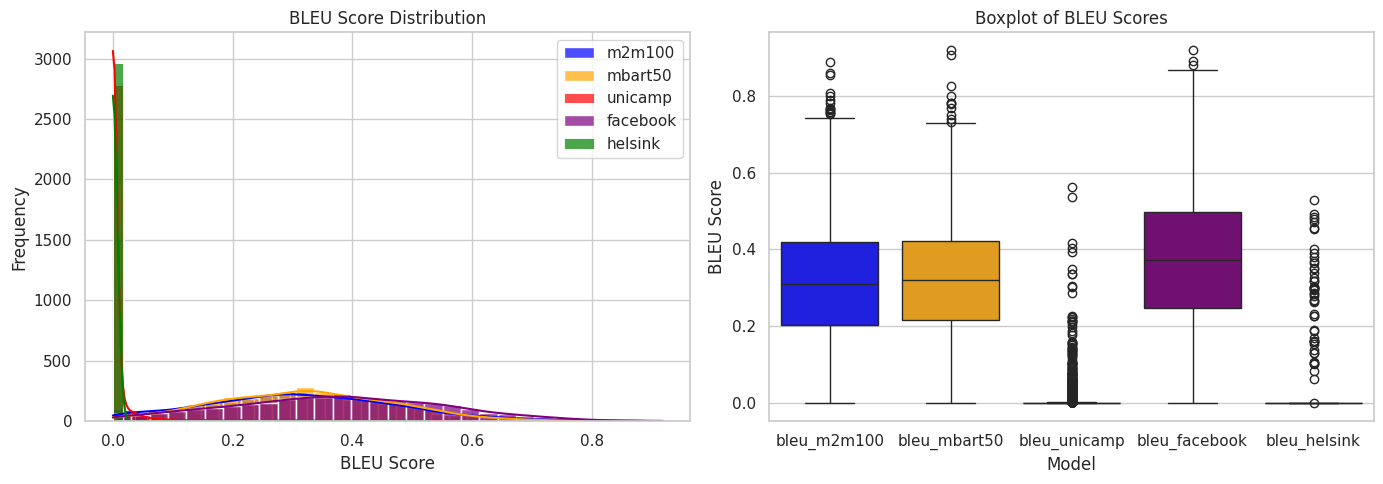

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df_merged["bleu_m2m100"], bins=30, color="blue", kde=True, label="m2m100", alpha=0.7)
sns.histplot(df_merged["bleu_mbart50"], bins=30, color="orange", kde=True, label="mbart50", alpha=0.7)
sns.histplot(df_merged["bleu_unicamp"], bins=30, color="red", kde=True, label="unicamp", alpha=0.7)
sns.histplot(df_merged["bleu_facebook"], bins=30, color="purple", kde=True, label="facebook", alpha=0.7)
sns.histplot(df_merged["bleu_helsink"], bins=30, color="green", kde=True, label="helsink", alpha=0.7)
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.legend()

# Boxplot comparativo
plt.subplot(1, 2, 2)
sns.boxplot(
    data=df_merged[[
        "bleu_m2m100", "bleu_mbart50", "bleu_unicamp", "bleu_facebook", 
        "bleu_helsink"
    ]],
    palette=["blue", "orange", "red", "purple", "green"]
)
plt.title("Boxplot of BLEU Scores")
plt.ylabel("BLEU Score")
plt.xlabel("Model")

plt.tight_layout()
plt.show()